# Optogenetic stimulation

How to inject an optogenetic intervention (opsin and optic fiber) into a simulation.

Preamble:

In [1]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import matplotlib.pyplot as plt

import cleosim
from cleosim import *

# numpy faster than cython for lightweight example
prefs.codegen.target = 'numpy'
# for reproducibility
np.random.seed(1866)

## Create a Markov opsin-compatible network
cleosim enables two basic approaches to modeling opsin currents. One is a fairly accurate Markov state model and the other is a simple proportional current model. We will look at the Markov model first.

The established Markov opsin models (as presented in [Evans et al., 2016](https://www.frontiersin.org/articles/10.3389/fninf.2016.00008/full)), are conductance-based and so depend on somewhat realistic membrane voltages. This disqualifies the most basic leaky integrate-and-fire neuron model which reset on reaching their rheobase threshold&mdash;staying perpetually in a subthreshold region produces exaggerated opsin currents and more spikes than expected. Quadratic or exponential integrate-and-fire neurons, however, can maintain simplicity while modeling the upward membrane potential swing we need for the opsin model to work realistically. Here we'll use the exponential flavor. For more info, see the [related section in the Neuronal Dynamics online textbook](https://neuronaldynamics.epfl.ch/online/Ch5.S2.html) and their [example parameters table](https://neuronaldynamics.epfl.ch/online/Ch6.S2.html#:~:text=Table%C2%A06.1%3A%20Exemplar%20parameters).

Note that we follow the conventions used in neuron modeling, where current is positive, rather than the conventions in opsin modeling, where the photocurrent is negative.

We'll use a small neuron group, biased by Poisson input spikes.

In [2]:
n = 10
ng = NeuronGroup(
    n,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + Rm*I) / tau_m : volt
    I : amp
    """,
    threshold="v>30*mV",
    reset="v=-55*mV",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70*mV,
    },
)
ng.v = -70 * mV

input_group = PoissonInput(ng, "v", n, 100 * Hz, 1 * mV)

mon = SpikeMonitor(ng)

net = Network(ng, input_group, mon)
ng.equations

dv/dt = (Delta_T*exp((-theta + v)/Delta_T) + E_L + I*Rm - v)/tau_m : volt
I : amp


## Assign coordinates and configure optogenetic model
The `OptogeneticIntervention` class implements the chosen opsin kinetics model with specified parameters. A standard four-state Markov model as well as channelrhodopsin-2 (ChR2) parameters are included with cleosim and are accessible in the `cleosim.opto` module. For extending to other models (such as three-state or six-state), see the [source code](https://github.com/kjohnsen/cleosim/blob/master/cleosim/opto.py)&mdash;the state equations, opsin-specific parameters, and light wavelength-specific parameters (if not using 473-nm blue) would be needed.

For reference, cleosim draws heavily on [Foutz et al., 2012](https://journals.physiology.org/doi/full/10.1152/jn.00501.2011) for the light propagation model and on [Evans et al., 2016](https://www.frontiersin.org/articles/10.3389/fninf.2016.00008/full) for the opsin kinetics model.

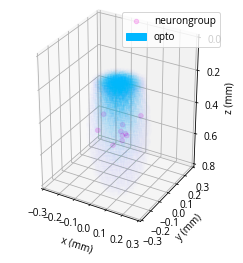

In [32]:
from cleosim.coordinates import assign_coords_rand_rect_prism
from cleosim.opto import *

assign_coords_rand_rect_prism(ng, xlim=(-0.1, 0.1), ylim=(-0.1, 0.1), zlim=(0.4, 0.6))

opto = OptogeneticIntervention(
    name="opto",
    opsin_model=FourStateModel(ChR2_four_state),
    light_model_params=default_blue,
    location=(0, 0, 0.2) * mm,
)

lim = .3
cleosim.visualization.plot(
    ng,
    colors=["xkcd:fuchsia"],
    xlim=(-lim, lim),
    ylim=(-lim, lim),
    # xlim=(-0.2, 0.2),
    # ylim=(-0.2, 0.2),
    zlim=(0, 0.8),
    devices=[(opto, {'n_points': 2e4})],  # num points used to visualize light
)

## Open-loop optogenetic stimulation
We need to inject our optogenetic intervention into the simulator. `cleosim` handles all the object creation and equations needed to interact with the existing Brian model without the need to alter it, with the possible exception of adding a variable to represent the opsin current. This needs to be specified upon injection with `Iopto_var_name=...` if not the default `Iopto`. The membrane potential variable name also needs to be specified (with `v_var_name=...`) if not the default `v`.

In [4]:
sim = CLSimulator(net)
sim.inject_stimulator(opto, ng, Iopto_var_name='I')

### IO processor setup

Here we design an IO processor that ignores measurements and simply sets the light intensity according to the `stimulus(t)` function:

In [5]:
from cleosim.processing import LatencyIOProcessor

def stimulus(time_ms):
    f = 30
    return 1 * (1 + np.sin(2*np.pi*f * time_ms/1000))

class OpenLoopOpto(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period_ms=1)

    # since this is open-loop, we don't use state_dict
    def process(self, state_dict, time_ms):
        opto_intensity = stimulus(time_ms)
        # return output dict and time
        return ({"opto": opto_intensity}, time_ms)

sim.set_io_processor(OpenLoopOpto())

### Run simulation and plot results

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]


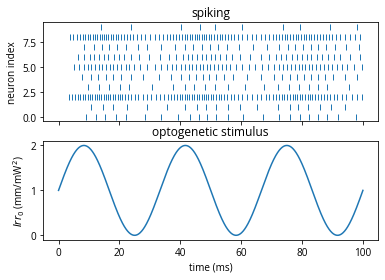

In [6]:
sim.run(100*ms)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(mon.t / ms, mon.i[:], '|')
ax1.set(ylabel='neuron index', title='spiking')
t_sim=np.linspace(0, 100, 1000)
ax2.plot(t_sim, stimulus(t_sim))
ax2.set(ylabel=r'$Irr_0$ (mm/mW$^2$)', title='optogenetic stimulus', xlabel='time (ms)');

## Conclusion
We can see clearly that firing rate correlates with light intensity as expected.

As a recap, in this tutorial we've seen how to:
* configure an `OptogeneticIntervention`,
* inject it into the simulation,
* and control its light intensity in an open-loop fashion.

## Appendix: simplified opsin model

Because cleosim is designed to be maximally compatible with existing Brian models, it would be a significant limitation to have to replace all simplified models with more sophisticated ones such as the ELIF model mentioned earlier.
Luckily, we can use a simple approximation that is much more flexible, requiring only a current term, of any unit, in the target neurons. 

The Markov models of opsin dynamics we've used so far produce a rise, peak, and fall to a steady-state plateau current when subjected to sustained light. Since they are conductance-based, the current also varies with membrane voltage, including during spikes.
The `ProportionalCurrentModel`, on the other hand, simply delivers current proportional to light intensity. 
This should be adequate for a wide range of use cases where the exact opsin current dynamics on short timescales don't matter so much and a sort of average current-light relationship will suffice.

We will compare the two here. First, the ELIF model and accompanying Markov model opsin injection:

In [7]:
eLIF = NeuronGroup(
    1,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + Rm*Iopto) / tau_m : volt
    Iopto : amp
    """,
    threshold="v>30*mV",
    reset="v=-55*mV",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70*mV,
    },
)
eLIF.v = -70 * mV
assign_coords_rand_rect_prism(eLIF, xlim=(0, 0), ylim=(0, 0), zlim=(0, 0))
eLIF_mon = StateMonitor(eLIF, "Iopto", record=True)
eLIF_spikes = SpikeMonitor(eLIF)
markov_opto = OptogeneticIntervention(
    name="markov_opto",
    opsin_model=FourStateModel(ChR2_four_state),
    light_model_params=default_blue,
)

### Configure the proportional current model
Now we prepare the LIF neurons and simplified opsin model. Note that the only parameter we need to set for the opsin model is the gain on light intensity, `Iopto_per_mW_per_mm2`.
Setting it to 0.5 here means that when the neuron receives 1 mW/mm2 of light intensity, the current will be 0.5.
Here that current is unitless, but we could have used amps or any other unit the model required.

In [8]:
lif = NeuronGroup(
    1,
    """dv/dt = (-v + Iopto) / (20*ms) : 1
    Iopto : 1""",
    threshold="v > 1",
    reset="v=0"
)
assign_coords_rand_rect_prism(lif, xlim=(0, 0), ylim=(0, 0), zlim=(0, 0))
lif_mon = StateMonitor(lif, "Iopto", record=True)
lif_spikes = SpikeMonitor(lif)
simple_opto = OptogeneticIntervention(
    name="simple_opto",
    # handpicked gain to make firing rate roughly comparable to ELIF
    opsin_model=ProportionalCurrentModel(Iopto_per_mW_per_mm2=240),
    light_model_params=default_blue,
)

### Simulation

And we set up the simulator:

In [9]:
sim = CLSimulator(Network(lif, lif_mon, lif_spikes, eLIF, eLIF_mon, eLIF_spikes))
sim.inject_stimulator(markov_opto, eLIF)
sim.inject_stimulator(simple_opto, lif)

We'll now run the simulation with light pulses of increasing amplitudes to observe the effect on the current.

In [10]:
# hand-picked range of amplitudes to show 0 to moderate firing rates
for Irr0_mW_per_mm2 in np.linspace(0.005, 0.03, 5):
    markov_opto.update(Irr0_mW_per_mm2)
    simple_opto.update(Irr0_mW_per_mm2)
    sim.run(60 * ms)
    markov_opto.update(0)
    simple_opto.update(0)
    sim.run(60 * ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'neurongroup_2', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]


### Results

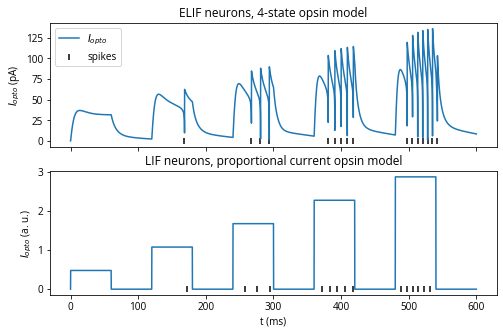

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
ax1.plot(eLIF_mon.t / ms, eLIF_mon.Iopto[0] / pamp, label="$I_{opto}$")
ax1.scatter(
    eLIF_spikes.t / ms, np.zeros_like(eLIF_spikes.t), marker="|", c="k", label="spikes"
)
ax1.set(title="ELIF neurons, 4-state opsin model", ylabel="$I_{opto}$ (pA)")
ax1.legend()
ax2.plot(lif_mon.t / ms, lif_mon.Iopto[0], label="$I_{opto}$")
ax2.scatter(
    lif_spikes.t / ms, np.zeros_like(lif_spikes.t), marker="|", c="k", label="spikes"
)
ax2.set(
    title="LIF neurons, proportional current opsin model",
    ylabel="$I_{opto}$ (a. u.)",
    xlabel="t (ms)",
);

Qualitatively we can see that the proportional current model doesn't capture the rise, peak, plateau, and fall dynamics that a Markov model can produce, but is a reasonable approximation if all you need is a roughly linear light intensity-firing rate relationship.